In [362]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [363]:
filename = 'resultado_V_Qout.txt'

data = pd.read_csv(filename,skiprows = 6,delim_whitespace=True,names=["Station", "Date", "Volume (m3)", "Qout (m3/d)"],  usecols=[1,2,3],na_values=-100.000)
data['Volume (m3)'] = data['Volume (m3)']*10**6
data['Qout (m3/d)'] = data['Qout (m3/d)']*86400
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.head()

C:\Users\Unieuro\AppData\Local\Temp\ipykernel_28500\2411817567.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filename,skiprows = 6,delim_whitespace=True,names=["Station", "Date", "Volume (m3)", "Qout (m3/d)"],  usecols=[1,2,3],na_values=-100.000)


,Date,Volume (m3),Qout (m3/d)
0,1993-10-01,NaN,NaN
1,1993-10-02,NaN,NaN
2,1993-10-03,NaN,NaN
3,1993-10-04,NaN,NaN
4,1993-10-05,NaN,NaN


In [364]:
data.index

RangeIndex(start=0, stop=10227, step=1)

In [365]:
datemask = (data['Date'] >= '01/01/2000' ) & (data['Date'] <= '31/12/2018' )
data = data[datemask]
data
#datemask


,Date,Volume (m3),Qout (m3/d)
2283,2000-01-01,62671000.0,993600.0
2284,2000-01-02,63059000.0,993600.0
2285,2000-01-03,63405000.0,993600.0
2286,2000-01-04,63708000.0,993600.0
2287,2000-01-05,63971000.0,963360.0
...,...,...,...
9218,2018-12-27,104420000.0,466819.2
9219,2018-12-28,104870000.0,474595.2
9220,2018-12-29,105320000.0,472262.4
9221,2018-12-30,105830000.0,414806.4


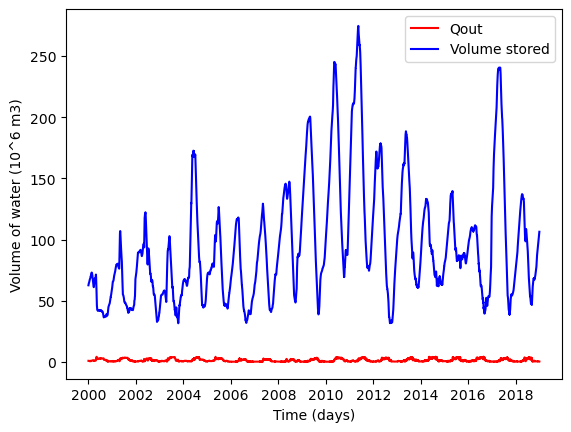

In [366]:
plt.plot(data['Date'], data['Qout (m3/d)']/(10**6), color = 'r', label = 'Qout')
plt.plot(data['Date'], data['Volume (m3)']/(10**6), color = 'b', label = 'Volume stored')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Volume of water (10^6 m3)')
plt.show()

We can consider the Tous dam as a cylindrical reservoir --> V(t) = Area(fixed)*h(t)

In [367]:
Area_Tous = 980 #ha
Area_Tous = Area_Tous*10**4 #m2


In [368]:
import xarray as xr

filename = "OBS6_ERA5_reanaly_1_day_pr_2000-2018.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
ds = xr.open_dataset(filename)
# Convert to a pandas DataFrame
df = ds.to_dataframe()
# Reset the index if needed
df.reset_index(inplace=True)
df = df[df['bnds'] == 0]
df.index = pd.to_datetime(df['time'])
df.index = df.index.normalize()
df.drop(columns=['time', 'bnds'], inplace=True)
prec  = df['pr']  # Precipitation data
prec  = prec*86400  # Convert from m/s to mm/day)
prec[prec < 0] = 0  # Set negative values to zero
#prec = prec[datemask]  # Filter the DataFrame for the desired date range


filename = "evaporation_Tous.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
dsEP = xr.open_dataset(filename)
# Convert to a pandas DataFrame
dfEP = dsEP.to_dataframe()
# Reset the index if needed
dfEP.reset_index(inplace=True)
EP = dfEP['evspsblpot']  # Evapotranspiration data
EP.index = pd.to_datetime(dfEP['time'])
EP.index = EP.index.normalize()
EP = EP*86400  # Convert from mm/s to mm/day)
EP[EP < 0] = 0  # Set negative values to zero
#EP = EP[datemask] 

In [369]:
EP = EP/(10**3)*Area_Tous
EP

time
2000-01-01    12109.825403
2000-01-02    12179.048555
2000-01-03     8510.703561
2000-01-04    12463.591212
2000-01-05    12532.580257
                  ...     
2018-12-27    12168.040156
2018-12-28     5023.836583
2018-12-29     8743.465544
2018-12-30    12889.386371
2018-12-31    13044.754575
Freq: D, Name: evspsblpot, Length: 6940, dtype: float64

In [370]:
prec=prec/(10**3)*Area_Tous
prec.max()

750961.7354348302

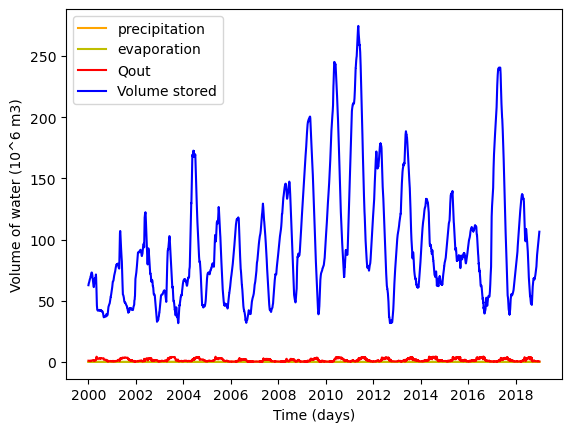

In [371]:
plt.plot(prec.index, prec/(10**6), color = 'orange', label = 'precipitation')
plt.plot(EP.index, EP/(10**6), color = 'y', label = 'evaporation')
plt.plot(data['Date'], data['Qout (m3/d)']/(10**6), color = 'r', label = 'Qout')
plt.plot(data['Date'], data['Volume (m3)']/(10**6), color = 'b', label = 'Volume stored')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Volume of water (10^6 m3)')
plt.show()

deltV = Qin - Qout + Prec -Evap

In [372]:
data.index

Index([2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292,
       ...
       9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222],
      dtype='int64', length=6940)

In [373]:
V = np.array(data['Volume (m3)'])
Qout = np.array(data['Qout (m3/d)'])
evap = np.array(EP)
precipitation = np.array(prec)
Qin = np.zeros(len(V))

In [374]:
range(1,len(V))

range(1, 6940)

deltV = Qin - Qout + prec - evap

In [375]:
for t in range(1,len(V)):
    Qin[t] = V[t] - V[t-1] + Qout[t] +evap[t]- precipitation[t] + evap[t]



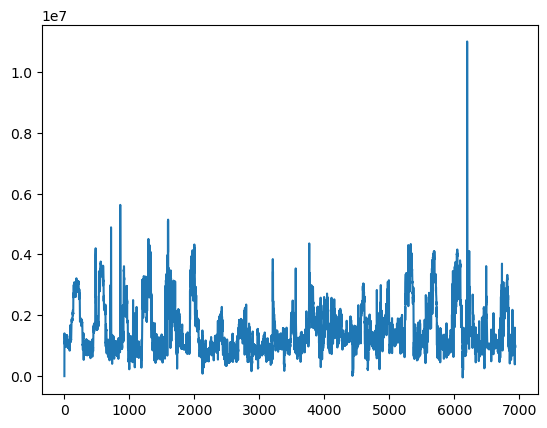

In [376]:
plt.plot(range(len(Qin)) , Qin)

In [377]:
data['Qin (m3/d)'] = Qin

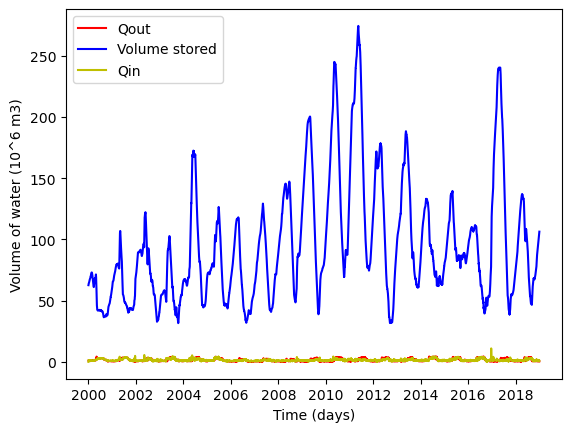

In [378]:
plt.plot(data['Date'], data['Qout (m3/d)']/(10**6), color = 'r', label = 'Qout')
plt.plot(data['Date'], data['Volume (m3)']/(10**6), color = 'b', label = 'Volume stored')
plt.plot(data['Date'], data['Qin (m3/d)']/(10**6), color = 'y', label = 'Qin')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Volume of water (10^6 m3)')
plt.show()

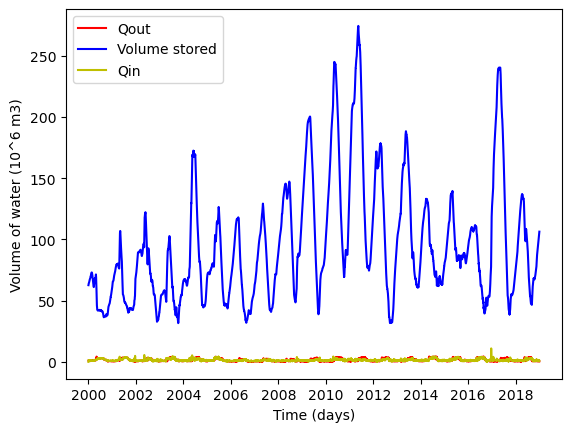

In [379]:
plt.plot(data['Date'], data['Qout (m3/d)']/(10**6), color = 'r', label = 'Qout')
plt.plot(data['Date'], data['Volume (m3)']/(10**6), color = 'b', label = 'Volume stored')
plt.plot(data['Date'], data['Qin (m3/d)']/(10**6), color = 'y', label = 'Qin')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Volume of water (10^6 m3)')
plt.show()

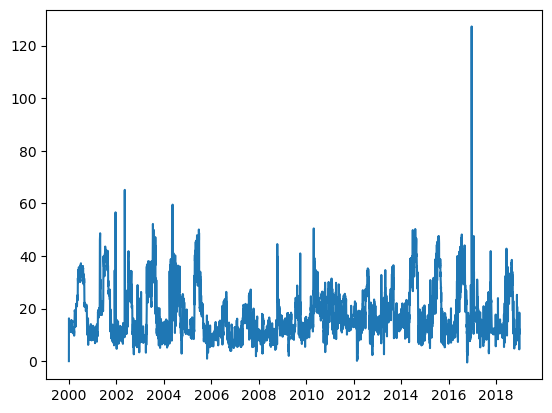

In [380]:
Qin_m3_s = Qin/86400
plt.plot(data['Date'] , Qin_m3_s)

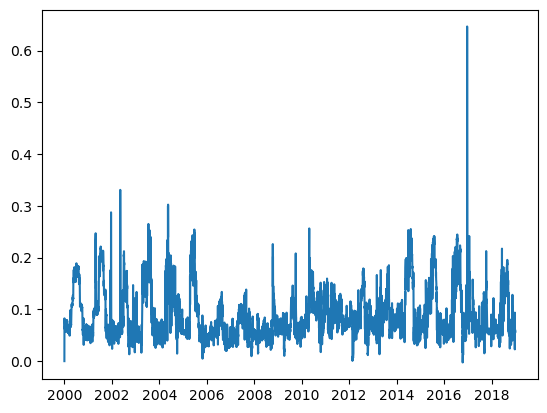

In [381]:
Area_catchment = 17002553159.970 #m2


Qin_mm_d = Qin/Area_catchment*10**3
plt.plot(data['Date'] , Qin_mm_d)

data['Qin (mm/d)'] = Qin_mm_d

In [382]:
data.to_csv("Upstream_Q.txt", sep="\t", index=False)